In [9]:
import numpy as np
from skimage.transform import resize
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Conv2D, ConvLSTM2D, TimeDistributed
from sklearn.externals import joblib
import pylidc as pl

from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
image_size = (256, 256)
num_slices = 50

In [3]:
unet = load_model('unet.hdf5')
lstm = load_model('unet_lstm.hdf5')

In [4]:
scans = pl.query(pl.Scan)
n = scans.count()

In [5]:
test = joblib.load('test_set.p')
train = list(set(range(n)) - set(test))

In [6]:
def get_data_unet(i):
    scan = scans[i]
    images = scan.load_all_dicom_images(verbose=False)
    n = len(images)
    X = np.array([resize(im.pixel_array, image_size, mode='constant') for im in images])
    X = np.expand_dims(X, axis=-1)
    y = np.zeros((512, 512, n))
    for ann in scan.annotations:
        b = ann.bbox()
        y[b] = np.logical_or(y[b], ann.boolean_mask())
    y = np.rollaxis(y, 2, 0)
    y = resize(y, (n, *image_size), mode='constant')
    y = np.expand_dims(y, axis=-1)
    start = np.random.randint(n - num_slices)
    X = X[start:start + num_slices]
    y = y[start:start + num_slices]
    return unet.predict(X, batch_size=1)[None], y[None]

In [27]:
# evaluate lstm
X, y = get_data_unet(np.random.choice(test))
preds_unet = X
fpr_unet, tpr_unet, _ = roc_curve(np.rint(y).flatten(), preds_unet.flatten())

preds_lstm = lstm.predict(preds_unet, batch_size=1)
fpr_lstm, tpr_lstm, _ = roc_curve(np.rint(y).flatten(), preds_lstm.flatten())

/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 49 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until


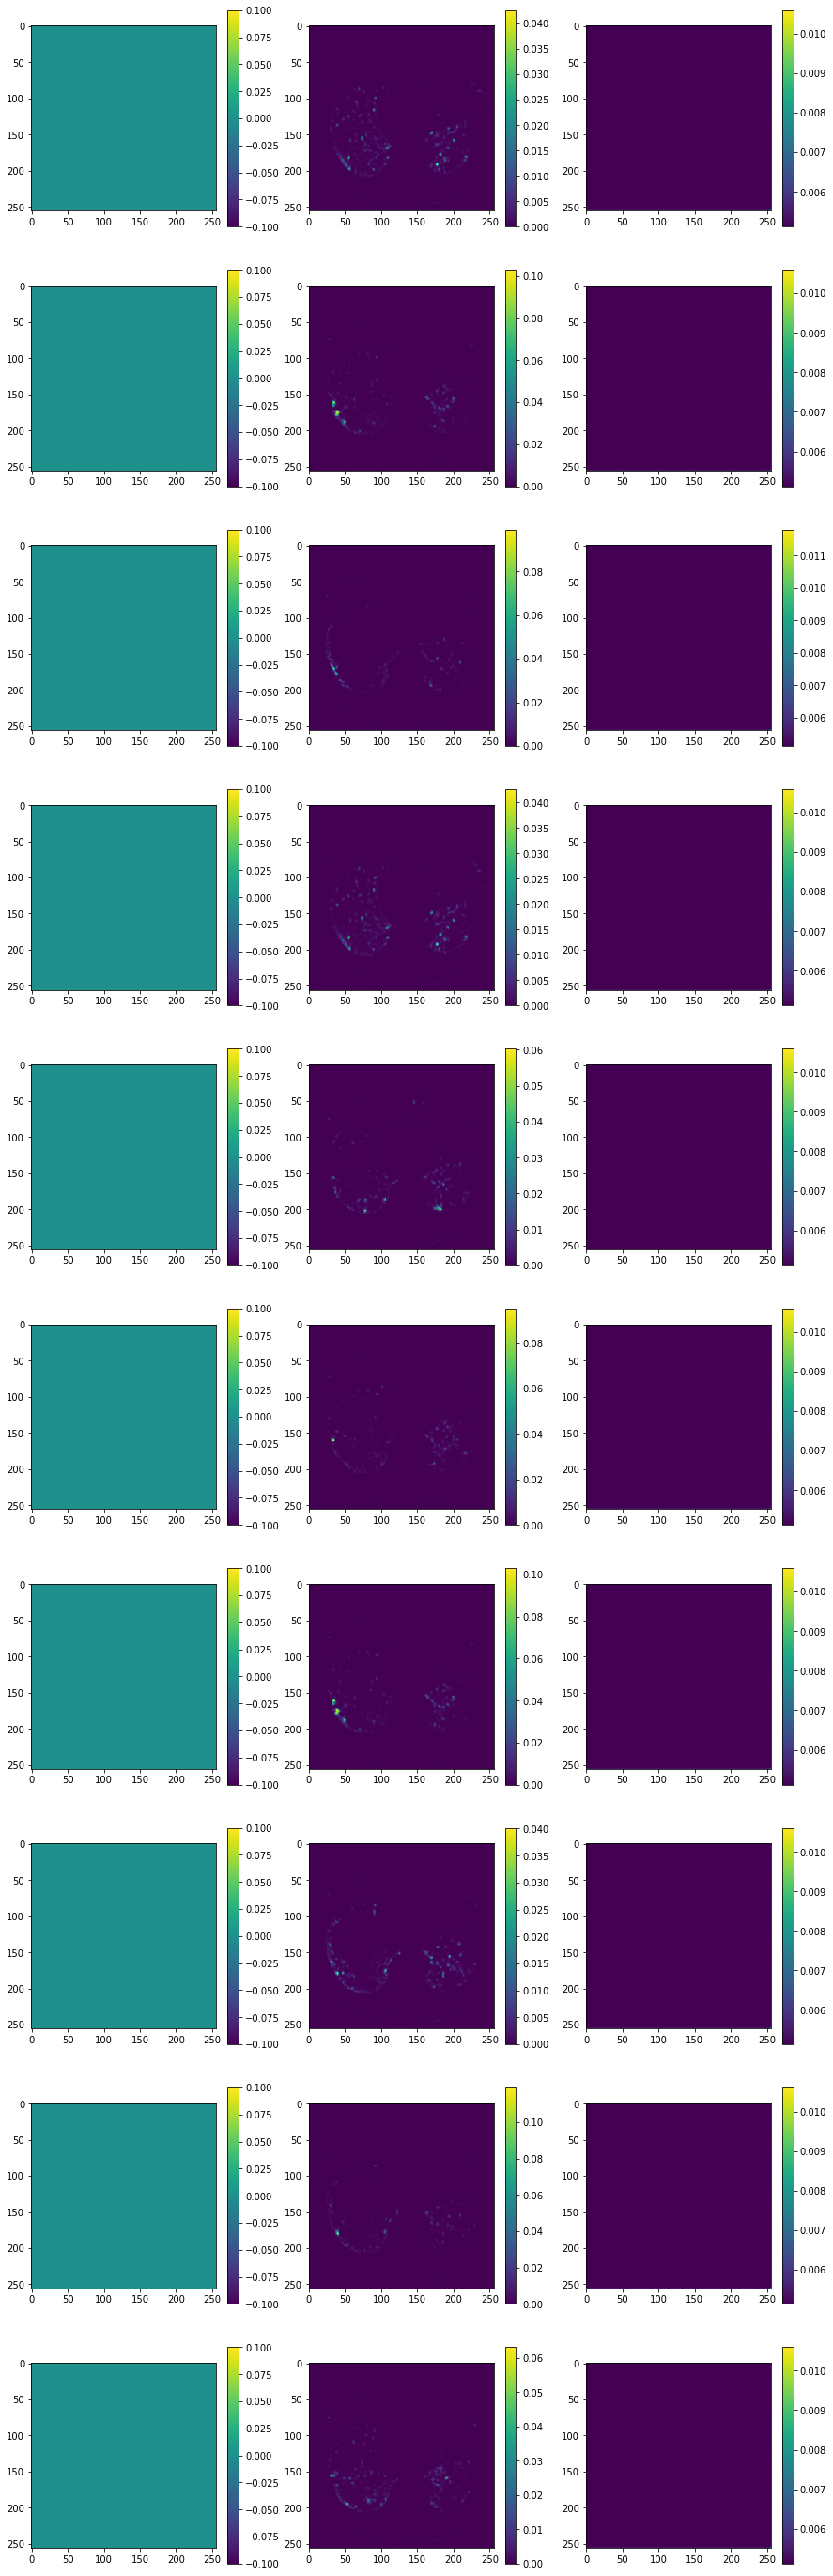

In [28]:
fig, ax = plt.subplots(10,3, figsize = (3*5,10*5))
for x in range(ax.shape[0]):
    z_slice = np.random.random_integers(0,high=X.shape[1]-1)
    a = ax[x,0].imshow(y[0,z_slice,:,:,0]) # ground truth
    fig.colorbar(a, ax=ax[x,0])
    b = ax[x,1].imshow(preds_unet[0,z_slice,:,:,0]) # unet pred
    fig.colorbar(b, ax=ax[x,1])
    c = ax[x,2].imshow(preds_lstm[0,z_slice,:,:,0]) # lstm pred
    fig.colorbar(c, ax=ax[x,2])

In [33]:
y

1

In [36]:
y.shape

(1, 50, 256, 256, 1)